In [2]:
import pandas as pd
import numpy as np
import pingouin as pg
from pathlib import Path
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import os.path as op

In [3]:
ANNOT_DIR = Path("derivatives/annotations")
OUT_DIR = Path("derivatives/caps/interrater")
OUT_DIR.mkdir(parents=True, exist_ok=True)

In [4]:
annot_df = pd.read_csv(op.join(ANNOT_DIR, "S01E01R01.csv"))  
episode_df = pd.read_csv(op.join(ANNOT_DIR, "S01E01.csv"))

In [37]:
annot_df.head()

,index,valence_1,valence_2,arousal_1,arousal_2
0,S01E01R01_clip0000,5,5,3,1
1,S01E01R01_clip0001,5,5,3,1
2,S01E01R01_clip0002,5,5,3,1
3,S01E01R01_clip0003,5,5,3,1
4,S01E01R01_clip0004,5,5,3,1


In [38]:
# Collect columns with 'valence' in their names
valence_cols = [col for col in annot_df.columns if 'valence' in col.lower()]
print("Valence columns found:")
print(valence_cols)
print(f"\nNumber of valence columns: {len(valence_cols)}")

# Display the valence data
print("\nValence data preview:")
annot_df[valence_cols].head()

Valence columns found:
['valence_1', 'valence_2']

Number of valence columns: 2

Valence data preview:


,valence_1,valence_2
0,5,5
1,5,5
2,5,5
3,5,5
4,5,5


In [39]:
# Collect columns with 'valence' in their names
arousal_cols = [col for col in annot_df.columns if 'arousal' in col.lower()]
print("Arousal columns found:")
print(arousal_cols)
print(f"\nNumber of arousal columns: {len(arousal_cols)}")

# Display the arousal data
print("\nArousal data preview:")
annot_df[arousal_cols].head()

Arousal columns found:
['arousal_1', 'arousal_2']

Number of arousal columns: 2

Arousal data preview:


,arousal_1,arousal_2
0,3,1
1,3,1
2,3,1
3,3,1
4,3,1


In [43]:
# Calculate ICC between valence_1 and valence_2
if len(valence_cols) >= 2:
    # Prepare data for ICC calculation
    valence_data = annot_df[valence_cols[:2]].copy()  # Take first 2 valence columns
    
    # Convert to numeric and remove any missing values
    valence_data = valence_data.apply(pd.to_numeric, errors='coerce').dropna()
    
    print(f"Calculating ICC between {valence_cols[0]} and {valence_cols[1]}")
    print(f"Valid data points: {len(valence_data)}")
    print(valence_data.var())

    
    # Reshape data for ICC calculation (long format)
    # valence_long = valence_data.reset_index().melt(
    #     id_vars='index', 
    #     var_name='rater', 
    #     value_name='valence'
    # )
    
    # # Calculate ICC(2,1) - Two-way random effects, absolute agreement, single measurement
    # icc_result = pg.intraclass_corr(
    #     data=valence_long, 
    #     targets='index', 
    #     raters='rater', 
    #     ratings='valence'
    # )
    
    # print(icc_result)

Calculating ICC between valence_1 and valence_2
Valid data points: 334
valence_1    0.000000
valence_2    1.205121
dtype: float64


In [5]:
episode_df.head()

,run,index,valence_1,valence_2,arousal_1,arousal_2
0,S01E01R01,S01E01R01_clip0000,5,5,3,1
1,S01E01R01,S01E01R01_clip0001,5,5,3,1
2,S01E01R01,S01E01R01_clip0002,5,5,3,1
3,S01E01R01,S01E01R01_clip0003,5,5,3,1
4,S01E01R01,S01E01R01_clip0004,5,5,3,1


Found 2 individual valence columns and 2 individual arousal columns
Valence columns: ['valence_1', 'valence_2']
Arousal columns: ['arousal_1', 'arousal_2']


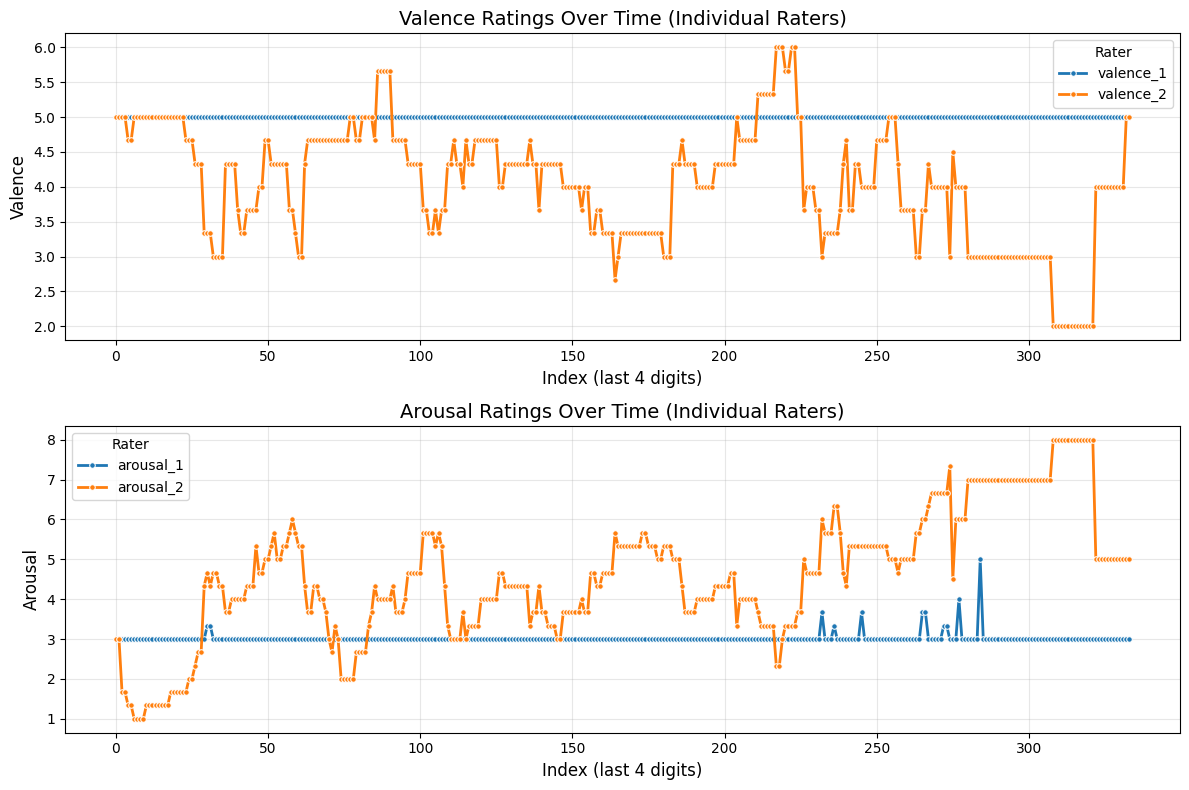

Index range: 0 - 333
Total data points: 885


In [8]:
# Create seaborn-style plot with index (last 4 digits) vs valence and arousal
# Extract last 4 digits of index
episode_df['index_short'] = episode_df['index'].astype(str).str[-4:].astype(int)

# Get valence and arousal columns (only individual rater columns, no averages)
val_cols = [col for col in episode_df.columns if 'valence' in col.lower() and ('_1' in col or '_2' in col)]
aro_cols = [col for col in episode_df.columns if 'arousal' in col.lower() and ('_1' in col or '_2' in col)]

print(f"Found {len(val_cols)} individual valence columns and {len(aro_cols)} individual arousal columns")
print(f"Valence columns: {val_cols}")
print(f"Arousal columns: {aro_cols}")

# Prepare data for seaborn (long format)
plot_data = []
for col in val_cols:
    for idx, row in episode_df.iterrows():
        plot_data.append({
            'index_short': row['index_short'],
            'rating': row[col],
            'emotion': 'Valence',
            'rater': col
        })

for col in aro_cols:
    for idx, row in episode_df.iterrows():
        plot_data.append({
            'index_short': row['index_short'],
            'rating': row[col],
            'emotion': 'Arousal',
            'rater': col
        })

plot_df = pd.DataFrame(plot_data)

# Create seaborn-style plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Plot valence
valence_data = plot_df[plot_df['emotion'] == 'Valence']
sns.lineplot(data=valence_data, x='index_short', y='rating', hue='rater', 
             marker='o', markersize=4, linewidth=2, ax=ax1, errorbar=None)
ax1.set_title('Valence Ratings Over Time (Individual Raters)', fontsize=14)
ax1.set_xlabel('Index (last 4 digits)', fontsize=12)
ax1.set_ylabel('Valence', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.legend(title='Rater')

# Plot arousal
arousal_data = plot_df[plot_df['emotion'] == 'Arousal']
sns.lineplot(data=arousal_data, x='index_short', y='rating', hue='rater', 
             marker='o', markersize=4, linewidth=2, ax=ax2, errorbar=None)
ax2.set_title('Arousal Ratings Over Time (Individual Raters)', fontsize=14)
ax2.set_xlabel('Index (last 4 digits)', fontsize=12)
ax2.set_ylabel('Arousal', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.legend(title='Rater')

plt.tight_layout()
plt.show()

print(f"Index range: {episode_df['index_short'].min()} - {episode_df['index_short'].max()}")
print(f"Total data points: {len(episode_df)}")